# Hamiltonian Simulation

## Overview

The goal in Hamiltonian simulation problems is to implement the map $H \mapsto \text{exp}(-i\tau H)$ for some Hermitian matrix $H$ (the Hamiltonian). Using QSP, we can reduce this problem to setting our target scalar function to $f(x) = \text{exp}(-i\tau x)$. Due to our parity constraint, the implementation of the target scalar function is separated into implementing components $f_{\text{Re}}(x) = \cos(\tau x)$ and $f_{\text{Im}}(x) = \sin(\tau x)$ respectively. These components can then be combined to realize $\text{exp}(-i\tau H)$ using linear combination of unitaries (LCU). To illustrate this workflow, we will choose $\tau = 100$.

In [15]:
tau = 100

opts = {
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'method': 'Newton' # MATLAB QSPPACK tutorial uses CM
}

## Solving for the real component

To increase the numerical stability, the real component of the target function is scaled down by a factor of $\frac{1}{2}$. This scaling causes the target function to be uniformly upper bounded by $\frac{1}{2}$. The Chebyshev coefficients of the target function are obtained by truncating the series to some finite degree, where it suffices to set $d=1.4|\tau|+\log\left( \frac{1}{\epsilon_0}\right)$ so that the truncation error is below $\epsilon_0$.

In [16]:
import numpy as np
from numpy.polynomial.chebyshev import chebinterpolate

# Define the target function
def targ(x):
    return 0.5 * np.cos(tau * x)

# Compute the degree for Chebyshev approximation
d = int(np.ceil(1.4 * tau + np.log(1e14)))+1
parity = d % 2

# Generate Chebyshev coefficients
xpts = np.cos(np.pi * (np.arange(d)+0.5) / d)
f_values = targ(xpts)
coef = chebinterpolate(targ, d)

# Discard coefficients of odd orders due to the even parity
print(f"Should be 0 due to even parity:\t{max(coef[parity+1::2])}")
coef_even = coef[parity::2]

Should be 0 due to even parity:	2.0301221021717148e-17


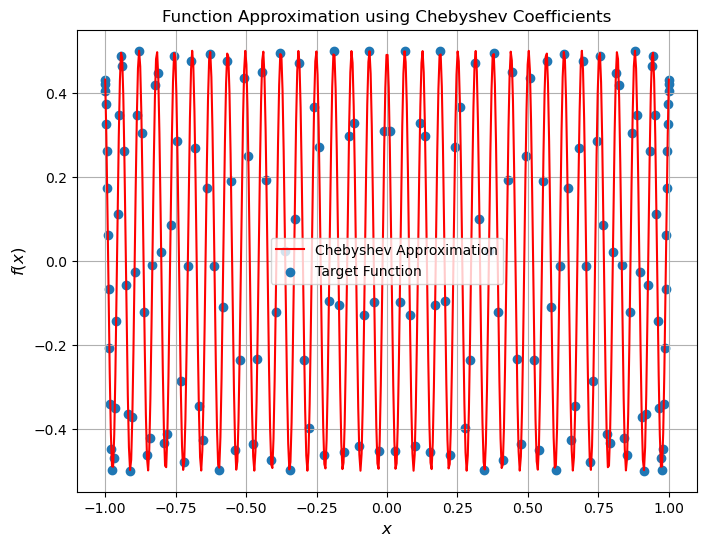

In [17]:
import matplotlib.pyplot as plt
from numpy.polynomial.chebyshev import chebval

# Define a range of x values for plotting
x_values = np.linspace(-1, 1, 500)

# Evaluate the Chebyshev polynomial at these x values
y_values = chebval(x_values, coef)

# Plot the function
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label='Chebyshev Approximation', color="red")
plt.scatter(xpts, f_values, label='Target Function')
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$f(x)$', fontsize=12)
plt.title('Function Approximation using Chebyshev Coefficients')
plt.legend()
plt.grid(True)
plt.show()


## Solving the phase factors and verifying

We can again use Newton's method to find the phase factors and verify the solution.

iter err          
   1  +1.7869e-01
   2  +1.8346e-03
   3  +1.4232e-07
Stop criteria satisfied.
   3  +1.4232e-07
Stop criteria satisfied.
The residual error is
5.873079800267078e-14
The residual error is
5.873079800267078e-14


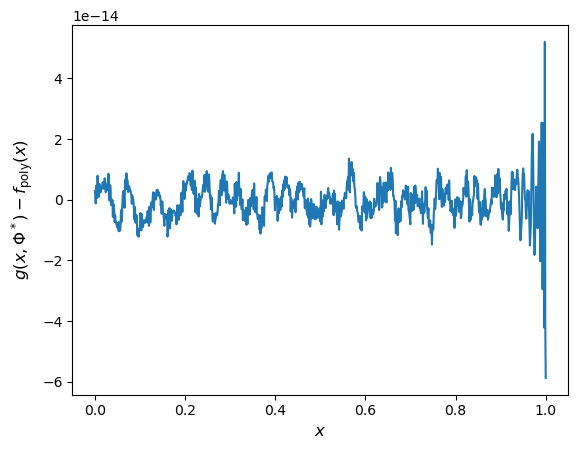

In [18]:
from qsppack.solver import solve
phi_proc, out = solve(coef_even, parity, opts)

from qsppack.utils import chebyshev_to_func, get_entry
import matplotlib.pyplot as plt

xlist = np.linspace(0, 1, 1000)
targ_value = targ(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - targ_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - targ_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

## Reference
1. Low, G. H., & Chuang, I. L. (2017). Optimal Hamiltonian simulation by quantum signal processing. *Physical review letters*, 118(1), 010501.

2. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).

3. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.

## Additional plots

Consider $f(x)=\frac{1}{2} \cos(100 x)$. We can first approximate $f(x)$ by an even polynomial $p(x)$ using Chebyshev interpolation, and then use Newton's method to find phase factors $\Psi$ such that $\Re[U_d(x,\Psi)]_{1,1}=p(x)$. 


In [23]:
# Recalculate with higher degree for high-precision example
d_high = 150
parity = 0  # Even parity for cosine function

# Generate Chebyshev coefficients with higher degree
coef_high = chebinterpolate(targ, d_high)

# Extract even coefficients only (due to even parity)
coef_even_high = coef_high[parity::2]

print(f"Degree of the approximating polynomial: {d_high}")
print(f"Number of even coefficients: {len(coef_even_high)}")

# Set up solver options - use Newton method like the working example
opts_high = {
    'maxiter': 100,
    'criteria': 1e-14,
    'useReal': True,
    'method': 'Newton'  
}

# Solve for phase factors
phi_proc_high, out_high = solve(coef_even_high, parity, opts_high)

print(f"Converged in {out_high['iter']} iterations")

Degree of the approximating polynomial: 150
Number of even coefficients: 76
iter err          
   1  +1.7869e-01
   2  +1.8346e-03
   3  +1.4232e-07
Stop criteria satisfied.
Converged in 4 iterations


In [20]:
# Evaluate the functions for comparison
xlist = np.linspace(0, 1, 1000)
targ_value = targ(xlist)
func_value = chebval(xlist, coef_high)  # Polynomial approximation
QSP_value_high = get_entry(xlist, phi_proc_high, out_high)

# Calculate errors
poly_error = np.linalg.norm(QSP_value_high - func_value, 1) / len(xlist)
qsp_error = np.linalg.norm(QSP_value_high - targ_value, 1) / len(xlist)

print('The QSP vs polynomial error is:', poly_error)
print('The QSP vs target error is:', qsp_error)

# Prepare phase factors with pi/4 removed from both ends
phi_shift = phi_proc_high.copy()
phi_shift[0] = phi_shift[0] - np.pi/4
phi_shift[-1] = phi_shift[-1] - np.pi/4

The QSP vs polynomial error is: 2.5865713040927432e-15
The QSP vs target error is: 5.542973564409519e-15


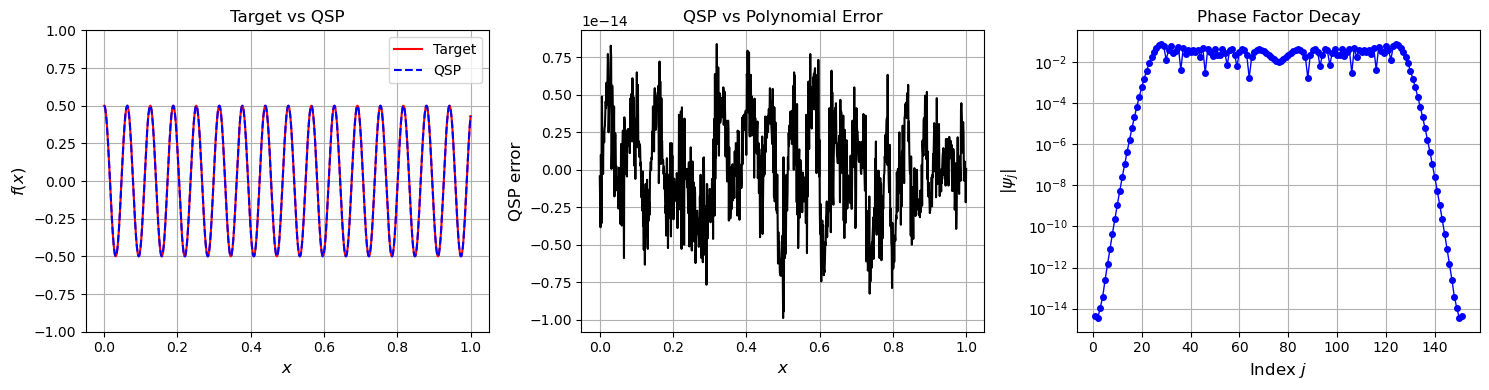

In [21]:
# Generate the three-subplot figure matching the MATLAB version
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Left subplot: polynomial approximation vs actual function
axes[0].plot(xlist, targ_value, 'r-', linewidth=1.5, label='Target')
axes[0].plot(xlist, QSP_value_high, 'b--', linewidth=1.5, label='QSP')
axes[0].set_xlabel('$x$', fontsize=12)
axes[0].set_ylabel('$f(x)$', fontsize=12)
axes[0].set_ylim([-1, 1])
axes[0].legend(loc='best')
axes[0].grid(True)
axes[0].set_title('Target vs QSP')

# Middle subplot: error between QSP and polynomial approximation
axes[1].plot(xlist, QSP_value_high - func_value, 'k-', linewidth=1.5)
axes[1].set_xlabel('$x$', fontsize=12)
axes[1].set_ylabel('QSP error', fontsize=12)
axes[1].grid(True)
axes[1].set_title('QSP vs Polynomial Error')

# Right subplot: phase factors (after removing pi/4 factor) on log scale
axes[2].semilogy(range(1, len(phi_shift)+1), np.abs(phi_shift), 'bo-', markersize=4, linewidth=1)
axes[2].set_xlabel('Index $j$', fontsize=12)
axes[2].set_ylabel('$|\\psi_j|$', fontsize=12)
axes[2].grid(True)
axes[2].set_title('Phase Factor Decay')

plt.tight_layout()
# plt.savefig('qsp_cos100x.png', dpi=300, bbox_inches='tight')
# print(f"Figure saved as 'qsp_cos100x.png'")
plt.show()
